# My YOLO-VGG
$\qquad \qquad \qquad \qquad \qquad -Xu \; Genli$

这是我第一篇比较完整的notebook,实现的是YOLO。这是我读完YOLO三篇论文之后边摸索边写的，这期间不断错不断改,没有参考任何教程（请允许我小骄傲一下^-^）(除了VGG架构是从吴老师那里拿来的,VGG信息密度低,计算量太大,之后要改用其他分类模型),代码,表和图都是自己完成的.当然，这也会造成代码质量不高甚至算法误解,我习惯在实践的过程中慢慢形成较深的认识,虽然这样效率比较低.如果和源码思路上有出入，或者算法的实现太过啰嗦、描述有误，请麻烦告知我.目前还没有整理代码,所有的代码都一股脑儿放在这里,有点杂乱无章,而且是用蹩脚的英文写的,有兴趣的同学直接看图表和对应结论就行.  
其实之前一直在做可视化的东西,但内容比较多,目前还没有实现完,希望之后能一样整理出来.
## - [Preparations](#preparation)
## - [Dimension clusters on Pascal VOC](#dimension_clusters)
## - [Load and transform xml to label for detection](#label)
## - [Build YOLO-VGG model](#model)
## - [Train model](#train)
## - [Inference](#test)
## - [Postprocess](#postprocess)

### General Inference Flow Path of YOLO-VGG
$$\text{}$$
- ${\frak{stage \; 1:}}$
$$
Raw \; image \quad
\frac{rescale}{} \quad
Standard \; input \quad
\frac{YOLO-VGG}{} \quad
\begin{cases}
\; t_o \\
\; t_x \\
\; t_y \\
\; t_w \\
\; t_h \\
\; c
\end{cases} \\
\text{}
$$
- ${\frak{stage \; 2}}$
$$\begin{cases}
\; t_o \\
\; t_x \\
\; t_y \\
\; t_w \\
\; t_h \\
\; c
\end{cases}
\Longrightarrow
\begin{cases}
Pr(object)*IOU_{pred}^{truth} = \sigma(t_o) \\
b_x = c_x + \require{cancel}\xcancel{\sigma(t_x)} t_x \\
b_y = c_y + \require{cancel}\xcancel{\sigma(t_y)} t_y \\
b_w = p_w * {\mit {e}}^{t_w}  \\
b_h = p_h * {\mit {e}}^{t_h}  \\
Pr(Class_i|Object) = \color{green}{softmax(c_i)}
\end{cases}
\Longrightarrow
\begin{cases}
Confidence = Pr(object)*IOU_{pred}^{truth} \\
xmin = max(b_x - \frac{b_w}{2}, 0) \\
ymin = max(b_y - \frac{b_h}{2}, 0) \\
xmax = min(b_x + \frac{b_w}{2}, W) \\
ymax = min(b_y + \frac{b_h}{2}, H) \\
Pr(Class_i) = Confidence * Pr(Class_i|Object)
\end{cases}
\quad \frac{rescale \; back}{} \quad\
bbox \\
$$
$$\text{} \\
\text{}$$
- ${\frak{stage \; 3}}$
$$
bbox \quad
\frac{Filter \; with \; confidence \; score}{} \quad
bbox \; with \; high \; confidence \quad
\frac{Non-max \; Suppression}{} \quad
final \; bbox
$$

<a id='preparation'></a>
# 1. Preparations

### - Import necessary packages

In [89]:
import os
import time
import numpy as np
import tensorflow as tf
from xml.dom.minidom import parse
import xml.dom.minidom
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### - Set Configurations

In [2]:
class CONFIG:
    
    # image configuration
    image_path = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages'
    xml_path = '/home/nio/Downloads/VOCdevkit/VOC2012/Annotations'
    #image_path = '/home/nio/Documents/xgl/dataset/VOCdevkit/VOC2012/JPEGImages'
    #xml_path = '/home/nio/Documents/xgl/dataset/VOCdevkit/VOC2012/Annotations'
    m = 17125  #size of dataset
    H = 416    #required image height
    W = 416    #required image width
    C = 3      #RGB channels
    MEANS = np.array([115.405466, 110.06217411, 101.88411205]).reshape([1, 1, 1, 3]) #calculated on the whole dataset
    
    # PASCAL VOC classes
    num_classes = 20
    classes = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 
               'horse': 5, 'sheep': 6, 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 
               'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 
               'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}
    class_names = {0: 'person', 1: 'bird', 2: 'cat', 3: 'cow', 4: 'dog', 
                   5: 'horse', 6: 'sheep', 7: 'aeroplane', 8: 'bicycle', 9: 'boat', 
                   10: 'bus', 11: 'car', 12: 'motorbike', 13: 'train', 14: 'bottle', 
                   15: 'chair', 16: 'diningtable', 17: 'pottedplant', 18: 'sofa', 19: 'tvmonitor'}
    
    # dimension clusters (obtained by myself)
    #num_dimension_cluster = 5
    #dimension_cluster = ([10, 13], [16, 30], [33, 23], [30, 61], [62, 45], 
    #                [59, 119], [116, 90], [156, 198], [373, 326])
    
    # dimension clusters (given by YOLOv3)
    num_dimension_cluster = 9
    dimension_cluster = ([10, 13], [16, 30], [33, 23], [30, 61], [62, 45], 
                    [59, 119], [116, 90], [156, 198], [373, 326])
    
    # grid cell configuration
    S = 13         #number of grid cell (height and width of ouput feature map)
    ws = W // S    #width of each grid cell
    hs = H // S    #height of each grid cell
    n = num_dimension_cluster * (5 + num_classes)  #every grid cell output n number, 
                                                   #9 dimension clusters * (to, tx, ty, tw, th, c1, ..., cn)
    
    
    # train configuration
    vgg_model_path = '/home/nio/Documents/xgl/code/model/imagenet-vgg-verydeep-19.mat'   #pretrained vgg-19 is used as a base model
    #vgg_model_path = '/home/nio/Documents/xgl/model/imagenet-vgg-verydeep-19.mat'
    batch_size = 16    #number of input image per training epoch
    num_batch = m // batch_size  #in training, I just don't use the this m % batch_size set of data
    
    # model saver configuration
    save_model_path = '/home/nio/Documents/xgl/code/model/model_yolo_vgg_new_nogd/yolo_vgg'
    weight_path = '/home/nio/Documents/xgl/code/model/model_yolo_vgg_new_nogd'
    #save_model_path = '/home/nio/Documents/xgl/model/model_yolo_vgg_new/yolo_vgg'
    #weight_path = '/home/nio/Documents/xgl/model/model_yolo_vgg_new'
    
    # trained model file
    yolo_vgg_model = '/home/nio/Documents/xgl/code/model/model_yolo_vgg_new_nogd/yolo_vgg-100.meta'
    #yolo_vgg_model = '/home/nio/Documents/xgl/model/model_yolo_vgg_new/yolo_vgg-4.meta'
    
    # filter predicted bounding box with score_threshold
    confidence_threshold = 0.6    #
    
    # filter predicted bounding box with iou_threshold, used in Non-max Suppression
    nms_threshold = 0.5

<a id='dimension_clusters'></a>
# 2. Dimension clusters on PASCAL VOC

### - Different choice of priors between algorithms
$\text{}$  
\begin{array}{c|c|c|c}
\text{Algorithm} & \text{prior} & \text{method} & \text{distance metric} \\
\hline
\text{Faster R-CNN} & \text{9 anchor boxes} & \text{hand-picking} & \text{-} \\
\text{YOLO} & \text{2 anchor boxes} & \text{hand-picking} & \text{-} \\
\text{YOLOv2} & \text{5 dimension clusters} & \text{K-Means} & \text{$d(box, centroid) = 1 - IOU(box, centroid)$} \\
\color{maroon}{\text{YOLOv3}} & \color{maroon}{\text{9 dimension clusters}} & \color{maroon}{\text{K-Means}} & \color{maroon}{\text{$d(box, centroid) = 1 - IOU(box, centroid)$}} \\
\end{array}
$\text{}$
    - In stead of using Euclidean distance in standard k-means, author takes the <font color='red'>"IOU distance"</font>. Compared to Euclidean distance, "IOU" distance balances the difference between large box and small box.  
$\text{}$   
### - Dimension clusters experiment
I try to do the same dimension clusters experiment as YOLOv2, the result is shown as below.  
What needs to be noticed is that, when I run K-Means on dimensions, I just use the max iteration to stop searching but not a criterion. Maybe I should set a threshold value on the change of average IOU, but I just found that result after 10000 iterations is similar to that of 1000. So I just let it be.

In [3]:
# read xmls to get height and width of ground truth bounding boxes
def get_dimensions(path):
    """
    Argumnets:
    path -- string, path of xml files
    
    Returns:
    dimensions -- array of shape (m, 2), every row is width and height of one bounding box
    """
    
    xml_files = os.listdir(path)
    m = len(xml_files)
    
    dimensions = np.empty((m, 2))
    
    for i, xml_file in enumerate(xml_files):
    
        DOMTree = xml.dom.minidom.parse(path + '/' + xml_file)
        collection = DOMTree.documentElement
        Objects = collection.getElementsByTagName("object")

        for Object in Objects:

            xmin = int(Object.getElementsByTagName('xmin')[0].childNodes[0].data)
            ymin = int(Object.getElementsByTagName('ymin')[0].childNodes[0].data.split('.')[0])
            xmax = int(Object.getElementsByTagName('xmax')[0].childNodes[0].data)
            ymax = int(Object.getElementsByTagName('ymax')[0].childNodes[0].data)
            
            width = xmax - xmin
            height = ymax - ymin
            dimensions[i, :] = np.array([width, height])
    
    assert(dimensions.shape == (m, 2))
        
    return dimensions

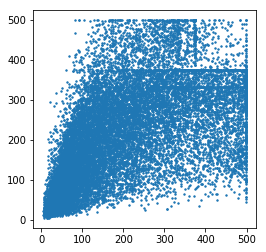

In [4]:
# show dimensions of all bounding boxes
dimensions = get_dimensions(CONFIG.xml_path)
plt.figure(figsize = (4, 4))
plt.scatter(dimensions[:, 0], dimensions[:, 1], s = 2)

In [3]:
# compute IOU distance between ground truth dimensions and a particular dimension prior
def IOU_distance(dimensions, prior):
    """    
    Arguments:
    dimensions -- array of shape (m, 2), dimensions of all the bounding boxes
    prior -- array of shape (k, 2), dimensions of one particular dimension prior
    
    Returns:
    iou_distance -- array of shape (m, 1), iou distance of all bounidng boxes with one particular dimension prior
    iou_score -- array of shape (m, 1), iou of all bounidng boxes with one particular dimension prior
    """
    
    x = np.concatenate([dimensions[:, 0].reshape([-1, 1]), prior[:, 0].reshape([-1, 1])], axis = 1)
    min_width = np.min(x, axis = 1)
    
    y = np.concatenate([dimensions[:, 1].reshape([-1, 1]), prior[:, 1].reshape([-1, 1])], axis = 1)
    min_height = np.min(y, axis = 1)
    
    #calculate intersection and union
    intersection = min_width * min_height
    union = dimensions[:, 0] * dimensions[:, 1] + prior[:, 0] * prior[:, 1] - intersection
    
    #calculate iou distance metric
    iou_distance = (1 - intersection / union)
    #record iou for later use (calculate average iou on different # of priors)
    iou_score = intersection / union
    
    return iou_distance, iou_score


# run k-means on dimensions using IOU distance metric
def IOU_K_MEANS(dimensions, k, maxiter):
    """
    Arguments:
    dimensions -- array of shape (m, 2), dimensions of all the bounding boxes
    k -- number of dimension clusters/priors
    maxiter -- max iterations for running K-Means
    
    Returns:
    centroid -- array of shape (k, 2), dimensions of best dimension clusters
    initial_centroid -- array of shape (k, 2), dimensions of randomly initialized dimension clusters
    avg_iou -- average iou obtained using k dimension clusters
    """
    
    m = dimensions.shape[0]
    np.random.seed(0)
    
    #get a proper range based on data to initialize dimension clusters
    min_width = np.min(dimensions[:, 0])
    max_width = np.max(dimensions[:, 0])
    min_height = np.min(dimensions[:, 1])
    max_height = np.max(dimensions[:, 1])
    centroid_width = np.random.randint(min_width, max_width, k).reshape((k, 1))
    centroid_height = np.random.randint(min_height, max_height, k).reshape((k, 1))
    initial_centroid = np.concatenate([centroid_width, centroid_height], axis = 1)
    
    #set variables to iteratively update dimension clusters
    centroid = np.empty((k, 2))
    new_centroid = np.empty((k, 2))
    
    iou_scores = np.zeros((m, k))
    avg_iou = []
    
    count = 0
    while count < maxiter:
    
        if count == 0:
            centroid = initial_centroid
        else:
            centroid = new_centroid
            
        distance_metric = np.empty((m, k))
        
        iou = 0.
        for i in range(k):

            single_centroid = np.tile(centroid[i, :].reshape((1, 2)), (m, 1))
            
            iou_distance, iou_score = IOU_distance(dimensions, single_centroid)

            distance_metric[:, i] = iou_distance
            
            if count == maxiter - 1:
                iou_scores[:, i] = iou_score
        
        #when the bounding box has the smallest iou distance with a particular dimension prior,
        #assign the index of that prior to the bbox as a label
        assign_type = np.argmin(distance_metric, axis = 1).reshape([-1, 1])
        
        for j in range(k):
            a = assign_type == j
            batch = a.sum()
            new_centroid[j, :] = np.sum(dimensions * a, axis = 0) / batch
            
            if count == maxiter - 1:
                avg_iou.append(np.sum(iou_scores[:, j].reshape([-1, 1]) * a) / batch)
                
        count += 1
    avg_iou = np.mean(np.array(avg_iou))
            
    return centroid, initial_centroid, avg_iou

In [6]:
#run k-means with iou distance
centroid, initial, avg_iou = IOU_K_MEANS(dimensions, k = 5, maxiter = 1000)

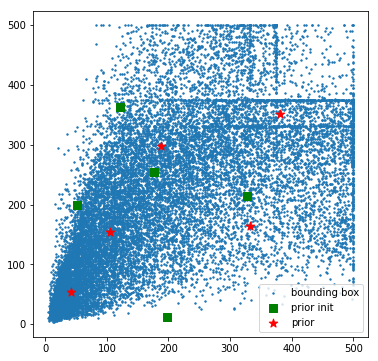

In [7]:
plt.figure(figsize = (6, 6))
plt.scatter(dimensions[:, 0], dimensions[:, 1], s = 2)
plt.scatter(initial[:, 0], initial[:, 1], s = 50, marker = 's', c = 'g')
plt.scatter(centroid[:, 0], centroid[:, 1], s = 80, marker = '*', c = 'r')
plt.legend(['bounding box', 'prior init', 'best prior'])

- Notice that you can't judge the centroid good or not in the Cartesian coordinate system, because it doesn't use Euclidean distance but IOU distance.

In [8]:
# calculate average iou with different number of dimension priors (from 1 to 15)
def average_iou_score(dimensions):
    
    avg_ious = []
    
    for i in range(1, 16):
        
        centroid, initial, avg_iou = IOU_K_MEANS(dimensions, k = i, maxiter = 1000)
            
        avg_ious.append(avg_iou)
    
    return avg_ious

In [9]:
avg_iou = average_iou_score(dimensions)

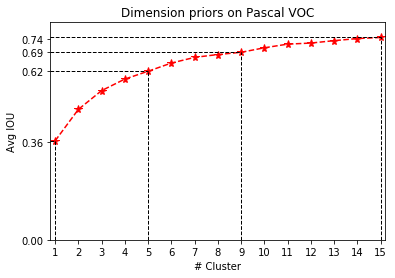

In [17]:
# plot avg iou trend
plt.plot(range(1, 16), avg_iou, 'r*--', markersize = 8)
plt.xlim([0.8, 15.2])
plt.xticks(range(1, 16))
plt.ylim([0, 0.8])
plt.yticks([0, round(avg_iou[0], 2), round(avg_iou[4], 2), round(avg_iou[8], 2), round(avg_iou[14], 2)])
plt.xlabel('# Cluster')
plt.ylabel('Avg IOU')
plt.title('Dimension priors on Pascal VOC')

# plot auxiliary line to better understand the plot
for i in [0, 4, 8, 14]:
    iou_level = avg_iou[i] * np.ones(100)
    vrange = np.linspace(0.8, i + 1, 100)
    plt.plot(vrange, iou_level, 'k--', linewidth = 1)
    cluster_num = (i + 1) * np.ones(100)
    hrange = np.linspace(0, avg_iou[i], 100)
    plt.plot(cluster_num, hrange, 'k--', linewidth = 1)

<a id='label'></a>
# 3. Load and transform xml to label for detection

### - What does the labelImg xml look like?  
$
<\color{purple}{annotation}>\\
\qquad <\color{purple}{folder}>VOC2012</\color{purple}{folder}>\\
\qquad <\color{purple}{filename}>2007\_000027.JPG</\color{purple}{filename}>\\
\;-<\color{purple}{source}>\\
\;\qquad <\color{purple}{database}>The VOC2007 Database</\color{purple}{database}>\\
\;\qquad <\color{purple}{annotation}>The VOC2007 Database</\color{purple}{annotation}>\\
\quad\;\,</\color{purple}{source}>\\
\;-<\color{purple}{size}>\\
\;\qquad<\color{purple}{width}>516</\color{purple}{width}>\\
\;\qquad<\color{purple}{height}>408</\color{purple}{height}>\\
\;\qquad<\color{purple}{depth}>3</\color{purple}{depth}>\\
\quad\;\,</\color{purple}{size}>\\
\quad\;\,<\color{purple}{segmented}>0</\color{purple}{segmented}>\\
\;-<\color{purple}{object}>\\
\;\qquad<\color{purple}{name}>sheep</\color{purple}{name}>\\
\;\qquad<\color{purple}{pose}>Unspecified</\color{purple}{pose}>\\
\;\qquad<\color{purle}{truncated}>0</\color{purple}{truncated}>\\
\;\qquad<\color{purple}{difficult}>0</\color{purple}{difficult}>\\
\quad\;\,-</\color{purple}{bndbox}>\\
\quad\;\,\;\qquad<\color{purple}{xmin}>171</\color{purple}{xmin}>\\
\quad\;\,\;\qquad<\color{purple}{ymin}>234</\color{purple}{ymin}>\\
\quad\;\,\;\qquad<\color{purple}{xmax}>456</\color{purple}{xmax}>\\
\quad\;\,\;\qquad<\color{purple}{ymax}>521</\color{purple}{ymax}>\\
\quad\;\;\quad</\color{purple}{bndbox}>\\
\quad\;\,</\color{purple}{object}>\\
\;-<\color{purple}{object}>\\
\;\qquad<\color{purple}{name}>person</\color{purple}{name}>\\
\;\qquad<\color{purple}{pose}>Unspecified</\color{purple}{pose}>\\
\;\qquad<\color{purple}{truncated}>0</\color{purple}{truncated}>\\
\;\qquad<\color{purple}{difficult}>0</\color{purple}{difficult}>\\
\quad\;\,-</\color{purple}{bndbox}>\\
\quad\;\,\;\qquad<\color{purple}{xmin}>67</\color{purple}{xmin}>\\
\quad\;\,\;\qquad<\color{purple}{ymin}>54</\color{purple}{ymin}>\\
\quad\;\,\;\qquad<\color{purple}{xmax}>234</\color{purple}{xmax}>\\
\quad\;\,\;\qquad<\color{purple}{ymax}>143</\color{purple}{ymax}>\\
\quad\;\;\quad</\color{purple}{bndbox}>\\
\quad\;\,</\color{purple}{object}>\\
</\color{purple}{annotation}>
$  
$\text{}$  

### - what should the ground truth label look like?   
- if
    - number of grid cells is 3x3
    - two dimension priors
    - three classes, car, cat and person
    - a cat's center is located at grid cell (1, 1), and its bounding box has larger IOU with dimension prior 1
    - a car's center is located at grid cell (2, 1), and its bounding box has larger IOU with dimension prior 2  

- then  
$y^{(i)}[0, 0] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[0, 1] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[0, 2] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[1, 0] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[1, 1] = \begin{pmatrix} 1 & b_x & b_y & b_w & b_h & 0 & 1 & 0 & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[1, 2] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[2, 0] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$y^{(i)}[2, 1] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 1 & b_x & b_y & b_w & b_h & 1 & 0 & 0 \end{pmatrix}$  
$y^{(i)}[2, 2] = \begin{pmatrix} 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? & 0 & \,? & \,\,? & \,\,\,? & \,\,\,\,? & \,? & ? & ? \end{pmatrix}$  
$$\text{}$$
- note  
At the very beginning, I took the background as a class too, and I add it (correctly predict class 'background' when there is no object in that grid cell) to the loss function. In this case, the model tends to struggle in predicting class correctly. And later I realized the confidence term already has the information that whether there is an object or not (1. confidence 0 for all anchors in irresponsible cells stands for background; 2. confidence 1 for responsible anchor in resonsible cell stands for some object; 3. confidence 0 for irresponsible anchor in responsible cell stands for not responsible), so I don't need to set a another class 'background'.
$\text{}$  

### - what should we do with the xml file?
- Transform the object name into class label (in one hot form)
- Transform the corner coordinates into the form of <font color='green'>center location and side length</font>
- use center location to find the <font color='red'>responsible grid cell</font> for detecting the object
- use the side length to calculate IOU with dimension priors and find the <font color='red'>responsible prior</font>

## 3.1 Get object information from xml file

In [92]:
## read xml file
def read_labelme_xml(xml_file):
    """
    Arguments:
    xml_file -- xml file name
    
    Returns:
    names -- list of object names
    coordinates -- list of coordinates of corresponding bouding box for each object
    """
    
    DOMTree = xml.dom.minidom.parse(xml_file)
    collection = DOMTree.documentElement
    Objects = collection.getElementsByTagName("object")
    
    names = []
    coordinates = []

    for Object in Objects:
        
        name = Object.getElementsByTagName('name')[0].childNodes[0].data
        names.append(name)
        
        xmin = int(Object.getElementsByTagName('xmin')[0].childNodes[0].data)
        ymin = int(Object.getElementsByTagName('ymin')[0].childNodes[0].data.split('.')[0])
        xmax = int(Object.getElementsByTagName('xmax')[0].childNodes[0].data)
        ymax = int(Object.getElementsByTagName('ymax')[0].childNodes[0].data)
        coordinates.append((xmin, ymin, xmax, ymax))
        
    return names, coordinates


## resize ground truth bounding box to normalized box as the image is resized to 416x416
def rescale_bbox(image_file, coordinates):
    """
    Arguments:
    image_file -- image file name
    coordinates -- coordinates of all bounding box in that image
    
    Returns:
    rescaled_coordinates -- rescaled coordinates as the image is resized to 416x416
    """
    
    img = scipy.misc.imread(image_file)
    
    H, W, C = img.shape
    scale_H = H / CONFIG.H
    scale_W = W / CONFIG.W
    
    rescaled_coordinates = []
    for coordinate in coordinates:
        
        xmin, ymin, xmax, ymax = coordinate
        
        rescaled_xmin = int(xmin / scale_W)
        rescaled_xmax = int(xmax / scale_W)
        rescaled_ymin = int(ymin / scale_H)
        rescaled_ymax = int(ymax / scale_H)
        
        rescaled_coordinates.append((rescaled_xmin, rescaled_ymin, rescaled_xmax, rescaled_ymax))
        
    return rescaled_coordinates


## plot bounding box 
def draw_ground_truth_bbox(image_file, object_names, coordinates, if_rescale=True):
    """
    Arguments:
    image_file
    object_names -- names of all objects in this image
    coordinates -- coordinates of all the bounding boxes in this image
    """
 
    fig = plt.figure(figsize = (14, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    img = scipy.misc.imread(image_file)
    
    rescaled_image = scipy.misc.imresize(img, (CONFIG.H, CONFIG.W))
    rescaled_coordinates = rescale_bbox(image_file, coordinates)
    
    # show raw image and bounding box
    ax1.imshow(img)
    ax2.imshow(rescaled_image)
    ax1.axis('off')
    ax2.axis('off')
    
    Fontsize = 10
    
    for i, object_name in enumerate(object_names):
        
        name_length = Fontsize * len(object_name)
        name_height = 1.8*Fontsize
        
        xmin, ymin, xmax, ymax = coordinates[i]
        
        rect1_1 = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r')
        rect1_2 = plt.Rectangle((xmin, ymin), name_length, -name_height, facecolor='r')
        
        ax1.add_patch(rect1_1)
        ax1.add_patch(rect1_2)
        ax1.text(xmin, ymin-Fontsize//2, object_name, family = 'monospace', fontsize = Fontsize, color = 'black')
        
        if if_rescale:
            
            rescaled_xmin, rescaled_ymin, rescaled_xmax, rescaled_ymax = rescaled_coordinates[i]
            
            rect2_1 = plt.Rectangle((rescaled_xmin, rescaled_ymin), 
                                rescaled_xmax - rescaled_xmin, rescaled_ymax - rescaled_ymin, fill=False, edgecolor='r')
            rect2_2 = plt.Rectangle((rescaled_xmin, rescaled_ymin), name_length, -name_height, facecolor='r')
            
            ax2.add_patch(rect2_1)
            ax2.add_patch(rect2_2)
            ax2.text(rescaled_xmin, rescaled_ymin-Fontsize//2, object_name, family = 'monospace', fontsize = Fontsize, color = 'black')

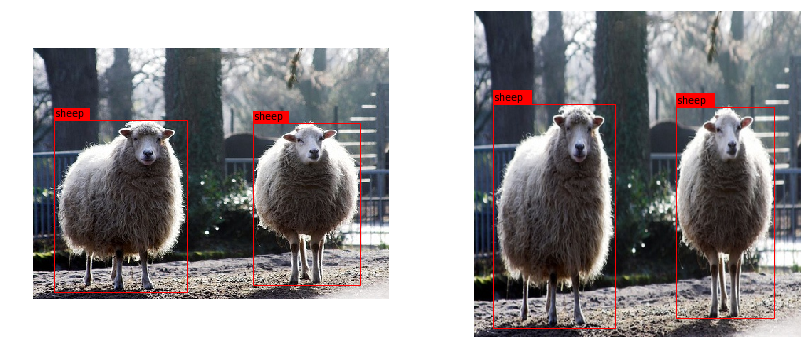

In [10]:
image_file = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages/2007_000925.jpg'
xml_file = '/home/nio/Downloads/VOCdevkit/VOC2012/Annotations/2007_000925.xml'

object_names, coordinates = read_labelme_xml(xml_file)
## test for raw image
draw_ground_truth_bbox(image_file, object_names, coordinates)

## 3.2 Transform bounding box coordinates into ground truth label
$\text{}$  
### - Find the responsible prior for detecting an object
$$\text{}$$
- First, find the grid cell. If the center of the object falls in a grid cell, this grid cell is responsible for detecting the object.
- Second, find the dimension prior in that grid cell (each grid cell outputs n dimension priors). The dimension prior that has the largest IOU with ground truth bbox is responsible for detecting that object.
- <font color='red'>So, one object should be detected by one particular dimension prior in one particular grid cell. However, from the view of receptive field and translation invariance of ConvNet, the nearby grid cell should have nearly the same output (the difference in input is only the location of object in their respective receptive field, translating by $2^5$ pixels). So YOLO attributes totally different label to nearby grid cell which should have nearly the same output, I think that's why YOLO has instability in training. It forces the additional layers to amplify the suttle difference in their input. And from the point of view, you can also figure out why nearby grid cell also output bounding box that can fit the object quite well.</font>  
$\text{}$  

### - Transformation between label and actual coordinates
$$\text{}$$
\begin{array}{c|c|c|c|c}
\text{} & \text{YOLO} & \text{R-CNN} & \text{YOLOv2} & \text{Here} \\
\hline
\text{} & \text{$b_x = t_x + c_x$} & \text{$b_x = t_x * p_w - p_x$} & \text{$b_x = \sigma(t_x) + c_x$} &  \color{red}{\text{$b_x = t_x + c_x$}}\\
\text{Coordinates} & \text{$b_y = t_y + c_y$} & \text{$b_y = t_y * p_h - p_y$} & \text{$b_y = \sigma(t_y) + c_y$} & \color{red}{\text{$b_y = t_y + c_y$}} \\
\text{} & \text{$b_w = t_w * W$} & \text{$b_w = p_w * e^{t_w}$} & \text{$b_w = p_w * e^{t_w}$} & \text{$b_w = p_w * e^{t_w}$}\\
\text{} & \text{$b_h = t_h * H$} & \text{$b_h = p_h * e^{t_h}$} & \text{$b_h = p_h * e^{t_h}$} & \text{$b_h = p_h * e^{t_h}$}\\
\end{array}
$\text{}$  

### - Comments
$$\text{}$$
- Though YOLO uses two anchor boxes, and the one has higher IOU with ground truth box is resiponsible for detecting that object, but YOLO finally predict coordinates directly as shown in the table rather than using anchor box. It's a weird thing, why bother adding anchor boxes? Model capacity also doesn't increase in this case.
- YOLO sets the coordinates of bounding box to be $\in(0, 1)$ but YOLOv2 doesn't, I will talk it later.
- In YOLO, YOLOv2 and Here $b_x$ and $b_y$ are relative to a particular grid cell, different from R-CNN.
$$\text{}$$  

#### - the reason in detail why I try to change the formula is stated [here](#label_design).

### 3.2.1 define functions to transform bbox coordinates into label

In [15]:
## convert corner coordinates to center coordinates + height and width
def convert_corner_to_center(coordinate):

    xmin, ymin, xmax, ymax = coordinate
    x_center = (xmin + xmax) // 2
    y_center = (ymin + ymax) // 2
    bw = xmax - xmin
    bh = ymax - ymin
    
    new_coordinate = (x_center, y_center, bw, bh)
    
    return new_coordinate

## caculate box area
def calculate_box_area(box):
    
    xmin, ymin, xmax, ymax = box
    area = (xmax - xmin) * (ymax - ymin)
    
    return area
## calculate IOU between two given boxes
def calculate_IOU(box1, box2):
    """
    box1 = [xmin1, ymin1, xmax1, ymax1]
    box2 = [xmin2, ymin2, xmax2, ymax2]
    """

    xmin = max(box1[0], box2[0])
    ymin = max(box1[1], box2[1])
    xmax = min(box1[2], box2[2])
    ymax = min(box1[3], box2[3])

    intersection = max(xmax - xmin, 0) * max(ymax - ymin, 0)
    union = calculate_box_area(box1) + calculate_box_area(box2) - intersection
    
    iou = intersection / union
    
    return iou


## find the anchor box that is responsible for detecting the object
def find_responsible_anchor_box(bw, bh, anchor_boxes):
    
    iou_list = []
    for anchor_box in anchor_boxes:
        
        pw, ph = anchor_box
        intersection = min(bw, pw) * min(bh, ph)
        union = bw * bh + pw * ph - intersection
        iou = intersection / union
        iou_list.append(iou)
    
    responsible_anchor_box_ix = int(np.argsort(iou_list)[-1])
    responsible_anchor_box = anchor_boxes[responsible_anchor_box_ix]
    
    return responsible_anchor_box_ix, responsible_anchor_box


## inverse function of sigmoid
def inverse_sigmoid(y):
    
    x = np.log(y / (1-y))
    
    return x

## transform xml file into label
def convert_xml_to_label(image_file, xml_file):
    
    label = np.zeros((CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))

    names, coordinates= read_labelme_xml(xml_file)
    coordinates = rescale_bbox(image_file, coordinates)

    for i, coordinate in enumerate(coordinates):
        
        name_ix = CONFIG.classes[names[i]]
        
        new_coordinate = convert_corner_to_center(coordinate)
        x_center, y_center, bw, bh = new_coordinate
        
        c_x = x_center // CONFIG.ws
        c_y = y_center // CONFIG.hs
        
        # location of groud truth bounding box
        bx = x_center / CONFIG.ws
        by = y_center / CONFIG.hs
        
        responsible_dimension_cluster_ix, responsible_dimension_cluster = find_responsible_anchor_box(bw, bh, CONFIG.dimension_cluster)
        # ground truth label
        pw, ph = responsible_dimension_cluster
        
        #YOLOv2 formula, dropped after experiment
        #tx = inverse_sigmoid(bx - c_x + 1e-8) #add 1e-8 to prevent the center of object is on the cell corner
        #ty = inverse_sigmoid(by - c_y + 1e-8)
        #YOLO-VGG formula
        tx = bx - c_x #add 1e-8 to prevent the center of object is on the cell corner
        ty = by - c_y
        tw = np.log(bw / pw)
        th = np.log(bh / ph)

        label[c_x, c_y, responsible_dimension_cluster_ix, :] = np.concatenate([[1, tx, ty, tw, th], 
                                                                              np.eye(CONFIG.num_classes)[name_ix]])
    
    return label


### 3.2.2 generate data and label in batch

In [7]:
## put all together to generate dataset (data and corresponding labels)
def generate_dataset(start_index, batch_size = CONFIG.batch_size):
    
    end_index = start_index + batch_size
    data = np.empty((batch_size, CONFIG.H, CONFIG.W, CONFIG.C))
    Label = np.empty((batch_size, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    
    files = os.listdir(CONFIG.image_path)
    
    for ix in range(start_index, end_index):
        
        image_file = CONFIG.image_path + '/' + files[ix]
        image = scipy.misc.imresize(scipy.misc.imread(image_file), (CONFIG.H, CONFIG.W)) - CONFIG.MEANS
        
        xml_file = CONFIG.xml_path + '/' + files[ix].split('.')[0] + '.xml'
        
        label = convert_xml_to_label(image_file, xml_file)
        
        data[ix - start_index] = image
        Label[ix - start_index] = label
    
    return data, Label

### 3.2.3 test for data generation

In [8]:
# load data and transform the label for the tvmonitor shown above
data, Label = generate_dataset(11417, batch_size = 1)

In [11]:
print('Shape of label is', Label.shape)
print('Index of responsible grid cell and dimension prior is (3, 8, 7) and (9, 8, 7)')
print('Vector of 7th responsible dimension prior in resposible grid cell is:')
print('Label of responsible cluster 1 is', Label[0][3][8][7])
print('Label of responsible cluster 2 is', Label[0][9][8][7])
print('Label of irresponsible cluster is', Label[0][1][8][7])

Shape of label is (1, 13, 13, 9, 25)
Index of responsible grid cell and dimension prior is (3, 8, 7) and (9, 8, 7)
Vector of 7th responsible dimension prior in resposible grid cell is:
Label of responsible cluster 1 is [ 1.          0.15625     0.15625    -0.00643089  0.36422215  0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Label of responsible cluster 2 is [ 1.          0.96875     0.03125    -0.22154227  0.30644435  0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Label of irresponsible cluster is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


<a id='label_design'></a>
### 3.2.4 distribution of bounding box label

In [22]:
dict_tx = []
dict_ty = []
dict_tw = []
dict_th = []

#I just stupid enough to use a lot of loops to create dictionaries
for i in range(CONFIG.m):
    _, Label = generate_dataset(i, batch_size = 1)
    for j in range(CONFIG.S):
        for k in range(CONFIG.S):
            for l in range(CONFIG.num_dimension_cluster):
                if Label[0, j, k, l, 0] == 1:
                    tx, ty, tw, th = Label[0, j, k, l, 1:5]
                    dict_tx.append(tx)
                    dict_ty.append(ty)
                    dict_tw.append(tw)
                    dict_th.append(th)
print('Capturing all bbox coordinates is done.')

Capturing all bbox coordinates is done.


Text(0.5,0,'YOLOv2 th')

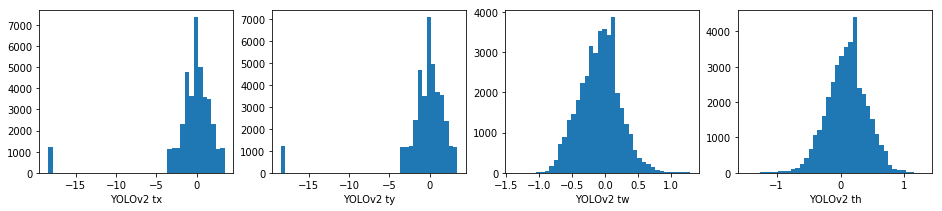

In [19]:
plt.figure(figsize = (16, 3))
plt.subplot(141)
plt.hist(dict_tx, 40)
plt.xlabel('YOLOv2 tx')
plt.subplot(142)
plt.hist(dict_ty, 40)
plt.xlabel('YOLOv2 ty')
plt.subplot(143)
plt.hist(dict_tw, 40)
plt.xlabel('YOLOv2 tw')
plt.subplot(144)
plt.hist(dict_th, 40)
plt.xlabel('YOLOv2 th')

- The definition of bbox label in YOLOv2 formula somehow constrains the range, especially $t_w$ and $t_h$, but using $\sigma$ makes range of $t_x$ and $t_y$ wider (as shown in the first two graph). This will cause inbalance in coordinates loss and make it be dominanted by location error, leading to more emphasis on $t_x$ and $t_y$. So I try to drop $\sigma$ to let $t_x$ and $t_y$ also range in [0, 1]. Here is an experiment I have done earlier. The last column shows that there is actually a inbalance between location and shape, because the network can predicts location right but not the shape.  
$\text{} \\$
$
\text{} \\ 
\begin{array}{c|c|c}
\text{$\lambda_{coord} : \lambda_{noobj} : \lambda_{class}$} & \text{5:0.5:1} & \text{5:0.0015:1}  & \text{5:0.0015:40} & \text{5:0.0015:20} & \text{5:0.0015:10}\\
\hline
\text{training} & \text{nan loss} & \text{ok} & \text{} & \text{}\\
\hline
\text{phenomenon} & \text{anchors confidence $\approx$ 0} & \text{predict everywhere with 'person'} & \text{serious location error} & \text{wrong location}& \text{wrong side length} \\
\text{reason} & \text{too many anchors with no object} & \text{loss is dominanted by $t_x$ and $t_y$ error} & \text{loss is dominanted by class error} & \text{$\lambda_{class}$ too big} & \text{inbalance loss between $t_x$ and $t_w$} \\
\hline
\text{solution} & \text{decrease $\lambda_{noobj}$} & \text{modify label formula} & \text{decrease $\lambda_{class}$} & \text{decrease $\lambda_{class}$} & \text{modify label formula}
\end{array}
$
$$\text{}$$
* #### Tips: 
       1. the items in this table will be explained later in this [loss function](#loss).
       2. the result may not be conclusive because I didn't training for enough epochs because of time consuming

### 3.2.5 modify label formula

Text(0.5,0,'YOLO-VGG th')

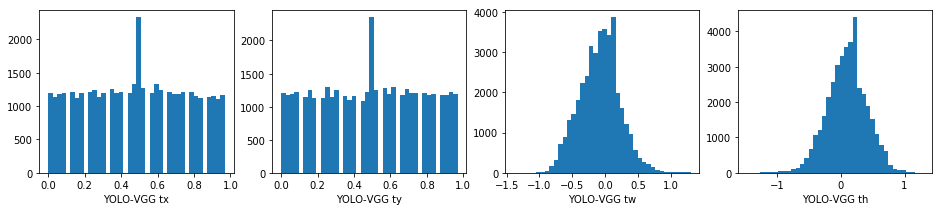

In [23]:
plt.figure(figsize = (16, 3))
plt.subplot(141)
plt.hist(dict_tx, 40)
plt.xlabel('YOLO-VGG tx')
plt.subplot(142)
plt.hist(dict_ty, 40)
plt.xlabel('YOLO-VGG ty')
plt.subplot(143)
plt.hist(dict_tw, 40)
plt.xlabel('YOLO-VGG tw')
plt.subplot(144)
plt.hist(dict_th, 40)
plt.xlabel('YOLO-VGG th')

### 3.2.6 ratio of responsible anchors to all
  
This ratio is used later when balancing loss between responsible boxes and background boxes.

In [25]:
m_bbox = len(dict_tx)
print('In VOC, %d images have %d labeled bounding boxes.'%(CONFIG.m, m_bbox))

YOLO_ratio_bbox_to_anchors = m_bbox / (17125*7*7*2) * 100
YOLOv2_ratio_bbox_to_anchors = m_bbox / (17125*13*13*5) * 100
Here_ratio_bbox_to_anchors = m_bbox / (17125*CONFIG.S*CONFIG.S*CONFIG.num_dimension_cluster)  * 100
print('YOLO: resiponsible anchors is nearly %.2f%% of all boxes.'%YOLO_ratio_bbox_to_anchors)
print('YOLOv2: resiponsible anchors is nearly %.2f%% of all boxes.'%YOLOv2_ratio_bbox_to_anchors)
print('Here: resiponsible anchors is nearly %.2f%% of all boxes.'%Here_ratio_bbox_to_anchors)

In VOC, 17125 images have 39404 labeled bounding boxes.
YOLO: resiponsible anchors is nearly 2.35% of all boxes.
YOLOv2: resiponsible anchors is nearly 0.27% of all boxes.
Here: resiponsible anchors is nearly 0.15% of all boxes.


<a id='model'></a>
# 4. Build YOLO-VGG model
### - YOLO-VGG structure
$$\text{}$$
I follow the YOLOv2 structure of the last few layers, but use the pretrained VGG-19 as the base model.  
Here are the important details: 
- Input size is increased from 224x224 to 416x416
- Load all the convolutional layers of pretrained VGG-19, and <font color='red'>don't fine tune them at all</font>, this shouldn't be right, but I have limited resource for training
- Add additional layers as YOLOv2 (but no passthrough layer). Layers are as follows:
    - 3x3 conv 1024
    - 1x1 conv $n_C$ ($n_C$ depend on the number of priors and number of object classes)
    - 3x3 conv 1024
    - 1x1 conv $n_C$
    - 3x3 conv 1024
    - 1x1 conv $n_C$
- Output feature dimension is designed to be (None, 13, 13, $n_C$)

### - Model configuration
$$\text{}$$
\begin{array}{c|c|c|c|c}
\text{YOLO-VGG} & \text{layer} & \text{config} & \text{output size} & \text{max nueron receptive field} \\
\hline
\text{} & \text{conv1_1} & \text{$3 \times 3 \times 64$} & \text{(416, 416, 64)} & \text{(3, 3)} \\
\text{} & \text{conv1_2} & \text{$3 \times 3 \times 64$} & \text{(416, 416, 64)} & \text{(5, 5)} \\
\text{} & \text{maxpool1} & \text{$2 \times 2 -s-2$} & \text{(208, 208, 64)} & \text{(10, 10)} \\
\text{} & \text{conv2_1} & \text{$3 \times 3 \times 128$} & \text{(208, 208, 128)} & \text{(12, 12)} \\
\text{} & \text{conv2_2} & \text{$3 \times 3 \times 128$} & \text{(208, 208, 128)} & \text{(14, 14)} \\
\text{} & \text{maxpool2} & \text{$2 \times 2 -s-2$} & \text{(104, 104, 128)} & \text{(28, 28)} \\
\text{} & \text{conv3_1} & \text{$3 \times 3 \times 256$} & \text{(104, 104, 256)} & \text{(30, 30)} \\
\text{} & \text{conv3_2} & \text{$3 \times 3 \times 256$} & \text{(104, 104, 256)} & \text{(32, 32)} \\
\text{} & \text{conv3_3} & \text{$3 \times 3 \times 256$} & \text{(104, 104, 256)} & \text{(34, 34)} \\
\text{} & \text{conv3_4} & \text{$3 \times 3 \times 256$} & \text{(104, 104, 256)} & \text{(36, 36)} \\
\text{VGG-19} & \text{maxpool3} & \text{$2 \times 2 -s-2$} & \text{(52, 52, 256)} & \text{(72, 72)} \\
\text{} & \text{conv4_1} & \text{$3 \times 3 \times 512$} & \text{(52, 52, 512)} & \text{(74, 74)} \\
\text{} & \text{conv4_2} & \text{$3 \times 3 \times 512$} & \text{(52, 52, 512)} & \text{(76, 76)} \\
\text{} & \text{conv4_3} & \text{$3 \times 3 \times 512$} & \text{(52, 52, 512)} & \text{(78, 78)} \\
\text{} & \text{conv4_4} & \text{$3 \times 3 \times 512$} & \text{(52, 52, 512)} & \text{(80, 80)} \\
\text{} & \text{maxpool4} & \text{$2 \times 2 -s-2$} & \text{(26, 26, 512)} & \text{(160, 160)} \\
\text{} & \text{conv5_1} & \text{$3 \times 3 \times 512$} & \text{(26, 26, 512)} & \text{(162, 162)} \\
\text{} & \text{conv5_2} & \text{$3 \times 3 \times 512$} & \text{(26, 26, 512)} & \text{(164, 164)} \\
\text{} & \text{conv5_3} & \text{$3 \times 3 \times 512$} & \text{(26, 26, 512)} & \text{(166, 166)} \\
\text{} & \text{conv5_4} & \text{$3 \times 3 \times 512$} & \text{(26, 26, 512)} & \text{(168, 168)} \\
\text{} & \text{maxpool5} & \text{$2 \times 2 -s-2$} & \text{(13, 13, 512)} & \text{(336, 336)} \\
\hline
\text{} & \text{conv6_1} & \text{$3 \times 3 \times 1024$} & \text{(13, 13, 1024)} & \text{(338, 338)} \\
\text{} & \text{conv6_2} & \text{$1 \times 1 \times n_C$} & \text{(13, 13, $n_C$)} & \text{(338, 338)} \\
\text{YOLO} & \text{conv6_3} & \text{$3 \times 3 \times 1024$} & \text{(13, 13, 1024)} & \text{(340, 340)} \\
\text{} & \text{conv6_4} & \text{$1 \times 1 \times n_C$} & \text{(13, 13, $n_C$)} & \text{(340, 340)} \\
\text{} & \text{conv6_5} & \text{$3 \times 3 \times 1024$} & \text{(13, 13, 1024)} & \text{(342, 342)} \\
\text{} & \text{conv6_6} & \text{$1 \times 1 \times n_C$} & \text{(13, 13, $n_C$)} & \color{red}{\text{(342, 342)}} \\
\end{array}
$$\text{}$$
Here is something I want to talk about the receptive field, but I will leave it to later work.

## 4.1 What remains to be done
- VGG-19 building is copy from Andrew Ng's deeplearning.ai, the data structure is somewhat complicated.  
- Actually, the VGG-19 is really a bad bad bad choice due to its computional cost and low information density, I use it just because I have used it for visualizaion for a long time. And the high resolution maintained through VGG (due to its small stride) constrianed the max batch size I can use, I just wanna cry when I got ResourceExhuasted Error -_-.I really should replace it with other models later;
- YOLOv2 <font color='red'>fine-tunes</font> the classification network (which is pretrained on Imagenet with 224x224 images) on 448x448 images;
- <font color='red'>Batch normalization</font> is needed for future development as suggested in YOLOv2;
- I have hard time trying to overfit the dataset, so I just don't use any regularization now.
- I should use He Kaiming's method to <font color='red'>initialize weights</font> for ReLU, but here I use Xavier initializer; I once tried the tf.contrib.layers.scaling_variance_initializer(), but the class loss term eplored to nan, I should look into this kind of initializer.
- YOLOv2 trained model on different size of images to improve its performance, but the paper didn't mention the method (<font color='red'>SPP</font> ? but how to deal with smaller input?);
- For detecting small objects, YOLOv2 uses a <font color='red'>passthrough layer</font> to stack 26x26x512 feature map from earlier layer with 13x13x512 (indeed it doesn't mention which feature map).

## 4.2 Build YOLO-VGG model

In [13]:
def load_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    #mean = vgg['normalization'][0][0][0]
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _maxpool(prev_layer):
        """
        Return the MaxPooling layer.
        """
        return tf.nn.max_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.placeholder(dtype = tf.float32, shape = (None, CONFIG.H, CONFIG.W, CONFIG.C))
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['maxpool1'] = _maxpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['maxpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['maxpool2'] = _maxpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['maxpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['maxpool3'] = _maxpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['maxpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['maxpool4'] = _maxpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['maxpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['maxpool5'] = _maxpool(graph['conv5_4'])
    
    graph['conv6_1'] = tf.contrib.layers.conv2d(graph['maxpool5'], 
                                                num_outputs = 1024, 
                                                kernel_size = 3, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = tf.nn.relu, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    graph['conv6_2'] = tf.contrib.layers.conv2d(graph['conv6_1'], 
                                                num_outputs = CONFIG.n, 
                                                kernel_size = 1, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = tf.nn.relu, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    graph['conv6_3'] = tf.contrib.layers.conv2d(graph['conv6_2'], 
                                                num_outputs = 1024, 
                                                kernel_size = 3, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = tf.nn.relu, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    graph['conv6_4'] = tf.contrib.layers.conv2d(graph['conv6_3'], 
                                                num_outputs = CONFIG.n, 
                                                kernel_size = 1, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = tf.nn.relu, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    graph['conv6_5'] = tf.contrib.layers.conv2d(graph['conv6_4'], 
                                                num_outputs = 1024, 
                                                kernel_size = 3, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = tf.nn.relu, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    graph['output'] = tf.contrib.layers.conv2d(graph['conv6_5'], 
                                                num_outputs = CONFIG.n, 
                                                kernel_size = 1, 
                                                stride = 1, 
                                                padding = 'same', 
                                                activation_fn = None, 
                                                weights_initializer = tf.glorot_normal_initializer(), 
                                                biases_initializer = tf.zeros_initializer()
                                               )
    print('Load YOLO-VGG model successfully!')
    
    return graph

In [14]:
# load VGG-19 pretrained weights to this model 
yolo_vgg = load_model(CONFIG.vgg_model_path)

Instructions for updating:
Use the retry module or similar alternatives.
Load YOLO-VGG model successfully!


<a id='train'></a>
# 5. Train model
### - Loss function
$$\text{}$$
$YOLO
\begin{cases}
\lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [(x_i - {\hat x}_i)^2 + (y_i - {\hat y}_i)^2]  \\
\qquad + \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [( \sqrt{w_i} - \sqrt{\hat{w_i}} )^2 + (\sqrt{h_i} - \sqrt{\hat{h_i}})^2]  \\
\qquad\qquad + \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} (C_i - {\hat C}_i)^2  \\
\qquad\quad + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{noobj} (C_i - {\hat C}_i)^2  \\
\qquad\qquad\qquad + \sum_{i=0}^{S^2} {\bf 1}_i^{obj} \sum_{c \in classes} (p_i(c) - {\hat p}_i(c))^2
\end{cases}$
  
$$\Downarrow \\
\text{}$$  
<a id='loss'></a>
$$ 
Here
\begin{cases}
\lambda_{coord} \begin{pmatrix} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [(\color{red}{t_{x \, ij}} - \hat{t_x}_{ \, ij})^2 + (t_{y \, ij} - \hat{t_y}_{ \, ij})^2] \;
+ \; \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [( t_{w \, ij} - \hat{t_w}_{ \, ij} )^2 + (t_{h \, ij} - \hat{t_h}{ \, ij})^2 ] \end{pmatrix} \\
\text{}  \\
\qquad\qquad + \; \begin{pmatrix} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} (C_{ij} - {\hat C}_{ij})^2 \;
+ \; \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{noobj} (C_{ij} - {\hat C}_{ij})^2 \\
\text{} \end{pmatrix} \\
\text{} \\
\qquad\qquad\qquad + \; \color{green}{\lambda_{class}} \begin{pmatrix} \sum_{i=0}^{S^2} \color{red}{\sum_{j=0}^{B} {\bf 1}_{ij}^{obj}} \sum_{c \in classes} (p_{ij}(c) - {\hat p}_{ij}(c))^2 
\require{enclose} \enclose{horizontalstrike, updiagonalstrike}{\color{red}{ + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} {\bf 1}_{ij}^{noobj} \sum_{c \in classes} (p_{ij}(c) - {\hat p}_{ij}(c))^2}} \end{pmatrix} \\
\end{cases}
$$

$$\text{}$$
    1. First, YOLO directly predict positions of bbox, YOLOv2 predicts modified offset of bbox, here I follow YOLOv2.
    2. Second, YOLOv2 take the ratio of shape between bounding box and its closest anchor box, changes in big boxes and small boxes is no longer a problem, so just throw away the sqrt operation.
    3. Third, YOLO predicts class every grid cell, but YOLOv2 predicts class every anchor box, here I follow YOLOv2. As claimed above, I realize it is not right to add the last term, in this way I just repeatedly penalize the box for not correctly predicting background and the result shows bad prediction for class. Since the confidence loss term has already done this and more, so I just remove it and drop the background class from the original classes.
    4. Forth, all loss function in YOLOs use sum-square error which weights localizaion error equally with classfication error. It may need to be modified later.

### - Details
$$\text{}$$  
- Choose $\lambda_{noobj}$
$$\text{}$$  
    - At the very beginning, I set the $\lambda_{noobj} = 0.5$ just as YOLO suggests. But I find the training very easy to diverge and the confidences of all anchors are every low. I had a hard time finding what was wrong, such as adjusting lr and checking the formulation. Later I realized that since my anchors is nearly 30 times more than YOLO's, I should set $\lambda_{noobj}$ to a much smaller value. Here I use 0.0015 which is design to balance the different loss term, but I think it may be too small and more value should be tested, but again, resource limited.
    - $\lambda_{noobj}$ is higher than $\frac{\sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj}}{\sum_{i=0}^{S^2} \sum_{j=0}^{B} {\bf 1}_{ij}^{noobj}}$, it is designed to balance the loss contribution of different kinds of anchors, and it emphasizes more (and can not be too much) on the anchors that have no object (i.e. contains background), I think this is a reason of why YOLO is less likely to predict false positives on background.
$$\text{}$$  
\begin{array}{c|c|c|c}
\text{VOC} & \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} & \sum_{i=0}^{S^2} \sum_{j=0}^{B} {\bf 1}_{ij}^{noobj} & \lambda_{noobj} \\
\hline
\text{YOLO} & \text{} & {17125 * 7 * 7 * {\xcancel 2} 1-39404} & 0.5 \\ 
\text{YOLOv2} & \text{39404} & {17125 * 13 * 13 * 5-39404} & \text{?} \\
\text{here} & \text{} & {17125 * 13 * 13 * 9 - 39404} & \text{0.0015} \rightarrow \text{0.01}
\end{array}
$$\text{}$$  
- Change from $\sqrt{w}$ to $t_w$
$$\text{}$$  
    - YOLO uses the square root of height and width, because small change of w (or h) in small boxes will cause decrease of IOU more than that in big boxes. But if we directly use w and h for computing loss, the loss function will equally evaluates the change for small boxes and big boxes, which is undesirable. YOLOv2 instead uses the value of ratio rather than the absolute value, eliminating the difference between small box and big box.

## 5.1 Define training process

$$ 
Here
\begin{cases}
\lambda_{coord} \begin{pmatrix} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [(t_{x \, ij} - \hat{t_x}_{ \, ij})^2 + (t_{y \, ij} - \hat{t_y}_{ \, ij})^2] \;
+ \; \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} [( t_{w \, ij} - \hat{t_w}_{ \, ij} )^2 + (t_{h \, ij} - \hat{t_h}{ \, ij})^2 ] \end{pmatrix} \\
\text{}  \\
\qquad\qquad + \; \begin{pmatrix} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{obj} (C_{ij} - {\hat C}_{ij})^2 \;
+ \; \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^B {\bf 1}_{ij}^{noobj} (C_{ij} - {\hat C}_{ij})^2 \\
\text{} \end{pmatrix} \\
\text{} \\
\qquad\qquad\qquad + \; \lambda_{class} \begin{pmatrix} \sum_{i=0}^{S^2} \sum_{j=0}^{B} {\bf 1}_{ij}^{obj} \sum_{c \in classes} (p_{ij}(c) - {\hat p}_{ij}(c))^2 
\end{pmatrix} \\
\end{cases}
$$


In [96]:
def tf_sigmoid(x):
    
    o = 1 / (1 + tf.exp(-x))
    
    return o

def tf_softmax(x):
    
    o = tf.exp(x) / tf.reduce_sum(tf.exp(x), axis=-1, keepdims=True)
    
    return o

def compute_total_loss(label, output, lambd_noobj):
    
    #difference at center location
    center_location_loss = tf.reduce_sum(tf.multiply(tf.expand_dims(label[:, :, :, :, 0], -1), 
                                                     tf.square(label[:, :, :, :, 1:3] - output[:, :, :, :, 1:3])))
    
    #side_length_loss = tf.reduce_sum(tf.multiply(tf.expand_dims(label[ :, :, :, 0], -1), 
    #                                             tf.square(tf.sqrt(label[:, :, :, :, 3:5]) - tf.sqrt(output[:, :, :, :, 3:5]))))
    #difference at width and height
    side_length_loss = tf.reduce_sum(tf.multiply(tf.expand_dims(label[:, :, :, :, 0], -1), 
                                                 tf.square(label[:, :, :, :, 3:5] - output[:, :, :, :, 3:5])))
    
    #difference of confidence (whether and how much the predicted bbox covers an object)
    confidence_loss_obj = tf.reduce_sum(tf.multiply(label[:, :, :, :, 0], 
                                                    tf.square(label[:, :, :, :, 0] - tf_sigmoid(output[:, :, :, :, 0]))))
    confidence_loss_noobj = tf.reduce_sum(tf.multiply(1 - label[:, :, :, :, 0], 
                                                      tf.square(label[:, :, :, :, 0] - tf_sigmoid(output[:, :, :, :, 0]))))
    
    #difference of classes
    class_loss_obj = tf.reduce_sum(tf.multiply(tf.expand_dims(label[:, :, :, :, 0], -1), 
                                               tf.square(label[:, :, :, :, 5:] - tf_softmax(output[:, :, :, :, 5:]))))
    #class_loss_noobj = tf.reduce_sum(tf.multiply(1 - tf.expand_dims(label[:, :, :, :, 0], -1), 
    #                                             tf.square(label[:, :, :, :, 5:] - tf_softmax(output[:, :, :, :, 5:]))))
    
    #total loss for each item
    bounding_box_loss = center_location_loss + side_length_loss
    confidence_loss = confidence_loss_obj + lambd_noobj * confidence_loss_noobj
    class_loss = class_loss_obj #+ lambd_noobj * class_loss_noobj
    #loss summary
    loss = [bounding_box_loss, confidence_loss, class_loss]
    
    return loss

## define loss function / search for learning rate / train
def train_yolo_vgg(model, lambd_coord, lambd_class, lambd_noobj, lr, epochs, configs, if_search_lr = False):
    """
    Arguments:
    model -- yolo-vgg model
    lambd_coord -- scalar, weight for coordinate loss
    lambd_noobj -- scalar, weight for grid cells that are not responsible for detecting object
    lr -- scalar, learning rate
    epochs -- scalar, max iteration to train
    configs -- list containing:
                expo_range_for_lr -- learning rate's exponential range to search
                num_search -- number of searches using different learning rate
                epochs_per_search -- iterations to train every search
    if_search_lr -- bool, search for lr when 'True', train when 'False'
    """
    
    np.random.seed(0)
    sess = tf.InteractiveSession()
    
    Y = tf.placeholder(dtype = tf.float32, shape = (None, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    y = tf.reshape(model['output'], (-1, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    
    #loss function
    loss = compute_total_loss(Y, y, lambd_noobj)
    bounding_box_loss, confidence_loss, class_loss = loss
    #total loss
    loss_to_optimize = lambd_coord*bounding_box_loss + confidence_loss + lambd_class*class_loss
    
    Train_Loss = []
    Val_Loss = []
    Train_Loss_bbox = []
    Train_Loss_confidence = []
    Train_Loss_class = []
    
    #take the last 2048 images as validation set
    train_batch_num = CONFIG.num_batch - 2048//CONFIG.batch_size
    #print('Loss is listed as (Total Loss, Bbox Loss, Confidence Loss, Class Loss)')
    # search for learning rate
    if if_search_lr:
        
        expo_range_for_lr, num_search, epochs_per_search = configs
        
        for k in range(num_search):
            
            start_time = time.time()
            
            #randomly choose learning rate in the log space
            lower, upper = expo_range_for_lr
            try_lr = 10 ** np.random.uniform(lower, upper)

            train_op = tf.train.AdamOptimizer(try_lr).minimize(loss_to_optimize)
            init = tf.global_variables_initializer()
            sess.run(init)
            
            for i in range(epochs_per_search):
                
                train_bbox_loss_per_epoch = 0.
                train_confidence_loss_per_epoch = 0.
                train_class_loss_per_epoch = 0.
                
                val_bbox_loss_per_epoch = 0.
                val_confidence_loss_per_epoch = 0.
                val_class_loss_per_epoch = 0.
                
                for j in range(train_batch_num):
                    
                    #use a single batch one forward and backward propagation
                    ix = j * CONFIG.batch_size
                    data, Label = generate_dataset(start_index = ix, batch_size = CONFIG.batch_size)

                    current_bbox_loss, current_confidence_loss, current_class_loss, _ = sess.run([bounding_box_loss, confidence_loss, class_loss, train_op], 
                                                                                                 feed_dict = {model['input']: data, Y: Label})
                    
                    train_bbox_loss_per_epoch += current_bbox_loss / train_batch_num
                    train_confidence_loss_per_epoch += current_confidence_loss / train_batch_num
                    train_class_loss_per_epoch += current_class_loss / train_batch_num
                
                train_total_loss_per_epoch = lambd_coord*train_bbox_loss_per_epoch + train_confidence_loss_per_epoch + lambd_class*train_class_loss_per_epoch
            
                for j in range(train_batch_num, CONFIG.num_batch):
                    
                    ix = j * CONFIG.batch_size
                    data, Label = generate_dataset(start_index = ix, batch_size = CONFIG.batch_size)

                    current_bbox_loss, current_confidence_loss, current_class_loss, _ = sess.run([bounding_box_loss, confidence_loss, class_loss, train_op], 
                                                                                                 feed_dict = {model['input']: data, Y: Label})
                    
                    val_bbox_loss_per_epoch += current_bbox_loss / val_batch_num
                    val_confidence_loss_per_epoch += current_confidence_loss / val_batch_num
                    val_class_loss_per_epoch += current_class_loss / val_batch_num
                val_total_loss_per_epoch = lambd_coord*val_bbox_loss_per_epoch + val_confidence_loss_per_epoch + lambd_class*val_class_loss_per_epoch
                
            consumed_time = time.time() - start_time
            print('Search %d. After %d epochs, with lr=%f and consuming time %.2f, train_loss and val_loss are: (%.4f, %.4f).'%(k, epochs_per_search, try_lr, consumed_time, train_total_loss_per_epoch, val_total_loss_per_epoch))
    
    #use best learning rate to train     
    else:
        
        lr_holder = tf.placeholder(dtype = tf.float32)
        train_op = tf.train.AdamOptimizer(lr_holder).minimize(loss_to_optimize)
        
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # save newest model (the latest max_to_keep model)
        saver = tf.train.Saver(max_to_keep=1)
        tf.add_to_collection("prediction", model['output'])
        
        for i in range(epochs_per_search):
                
            train_bbox_loss_per_epoch = 0.
            train_confidence_loss_per_epoch = 0.
            train_class_loss_per_epoch = 0.

            val_bbox_loss_per_epoch = 0.
            val_confidence_loss_per_epoch = 0.
            val_class_loss_per_epoch = 0.

            for j in range(train_batch_num):

                #use a single batch one forward and backward propagation
                ix = j * CONFIG.batch_size
                data, Label = generate_dataset(start_index = ix, batch_size = CONFIG.batch_size)

                current_bbox_loss, current_confidence_loss, current_class_loss, _ = sess.run([bounding_box_loss, confidence_loss, class_loss, train_op], 
                                                                                             feed_dict = {model['input']: data, Y: Label})

                train_bbox_loss_per_epoch += current_bbox_loss / train_batch_num
                train_confidence_loss_per_epoch += current_confidence_loss / train_batch_num
                train_class_loss_per_epoch += current_class_loss / train_batch_num

            train_total_loss_per_epoch = lambd_coord*train_bbox_loss_per_epoch + train_confidence_loss_per_epoch + lambd_class*train_class_loss_per_epoch

            for j in range(train_batch_num, CONFIG.num_batch):

                ix = j * CONFIG.batch_size
                data, Label = generate_dataset(start_index = ix, batch_size = CONFIG.batch_size)

                current_bbox_loss, current_confidence_loss, current_class_loss, _ = sess.run([bounding_box_loss, confidence_loss, class_loss, train_op], 
                                                                                             feed_dict = {model['input']: data, Y: Label})

                val_bbox_loss_per_epoch += current_bbox_loss / val_batch_num
                val_confidence_loss_per_epoch += current_confidence_loss / val_batch_num
                val_class_loss_per_epoch += current_class_loss / val_batch_num
            val_total_loss_per_epoch = lambd_coord*val_bbox_loss_per_epoch + val_confidence_loss_per_epoch + lambd_class*val_class_loss_per_epoch

            consumed_time = time.time() - start_time
            print('Epoch %d with lr %f. Time %.2f. train_loss and val_loss are (%.4f, %.4f). '%(i, lr, consumed_time, train_total_loss_per_epoch, val_total_loss_per_epoch))
            
            Train_Loss.append(train_total_loss_per_epoch)
            Val_Loss.append(val_total_loss_per_epoch)
            
            Train_Loss_bbox.append(train_bbox_loss_per_epoch)
            Train_Loss_confidence.append(train_confidence_loss_per_epoch)
            Train_Loss_class.append(trian_class_loss_per_epoch)
        
        saver.save(sess, CONFIG.save_model_path, global_step=i)
        print('Train is completed and the model yolo_vgg-%d is successfully saved.'%(i+1))
        
        Train_Loss_summary = (Train_Loss, Train_Loss_bbox, Train_Loss_confidence, Train_Loss_class)
        Loss_summary = (Train_Loss, Val_Loss)
        
        plt.figure(figsize = (14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(Train_Loss)
        plt.plot(Val_loss)
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend(['training loss', 'validation loss'])

        plt.subplot(1, 2, 2)
        plt.plot(Train_Loss_bbox)
        plt.plot(Train_Loss_confidence)
        plt.plot(Train_Loss_class)
        plt.title('Training loss distribution')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend(['coodinates loss', 'confidence loss', 'class loss'])
        
        return Train_Loss_summary, Loss_summary

## 5.2 Find the best learning rate

In [ ]:
# search for learning rate
train_yolo_vgg(model = yolo_vgg, lambd_coord = 5., lambd_class = 1., lambd_noobj = 1e-2, 
               lr = None, epochs = None, configs = [(-7, -3), 10, 1], if_search_lr = True)

## 5.3 Train

Loss is listed as (Total Loss, Bbox Loss, Confidence Loss, Class Loss)
Epoch 0 with lr 0.000020. (137.9136, 14.6249, 35.4210, 29.3679). Time 423.91.
Epoch 1 with lr 0.000020. (106.4140, 10.6155, 27.2671, 26.0695). Time 424.32.
Epoch 2 with lr 0.000020. (88.1708, 7.6213, 25.0681, 24.9962). Time 425.19.
Epoch 3 with lr 0.000020. (72.0311, 4.7949, 23.9229, 24.1339). Time 425.18.
Epoch 4 with lr 0.000020. (60.6290, 2.8448, 23.1137, 23.2911). Time 424.79.
Epoch 5 with lr 0.000020. (57.0755, 2.3954, 22.5161, 22.5824). Time 424.80.
Epoch 6 with lr 0.000020. (60.3642, 3.1987, 22.2063, 22.1642). Time 424.45.
Epoch 7 with lr 0.000020. (56.1354, 2.5603, 21.7341, 21.5998). Time 425.06.
Epoch 8 with lr 0.000020. (52.3149, 2.0080, 21.2937, 20.9811). Time 424.49.
Epoch 9 with lr 0.000020. (52.0195, 2.1278, 20.9624, 20.4180). Time 424.85.
Epoch 10 with lr 0.000020. (51.5108, 2.2020, 20.6290, 19.8716). Time 425.09.
Epoch 11 with lr 0.000020. (49.1593, 1.9446, 20.2012, 19.2351). Time 424.49.
Epoch 12 wi

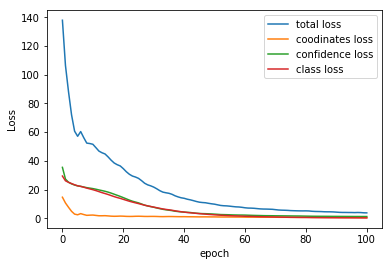

In [19]:
# use the best learning rate to train
best_lr = 2e-5
Loss_summary_10 = train_yolo_vgg(model = yolo_vgg, lambd_coord = 5., lambd_class = 1., lambd_noobj = 1e-2, 
                                 lr = best_lr, epochs = 100, configs = [(-7, -4), 10, 1], if_search_lr = False)

#### - As stated above, I modify the formula of location to balance loss value between location and shape. But this also makes coordinates error smaller than class error, the loss value is then dominated by class error. So I increase the weight of coordinates error. Here is a figure for this experiment.
$$\text{}$$
\begin{array}{c|c}
\text{$\frac{\lambda_{coord}}{\lambda_{class}}$} & \text{phenomenon} \\
\hline
\text{1:1} & \text{worst localization (10 epochs)} \\
\text{5:1} & \text{high score + low recall + bad localization + some wrong predict class (20 epochs)} \\
\text{10:1} & \text{high score + slightly better localization + some wrong predict class (50 epochs)} \\
\text{20:1} & \text{(100 epochs)} \\
\text{50:1} & \text{pretty good location + some wrong class 'person'(100 epochs)} 
\end{array}

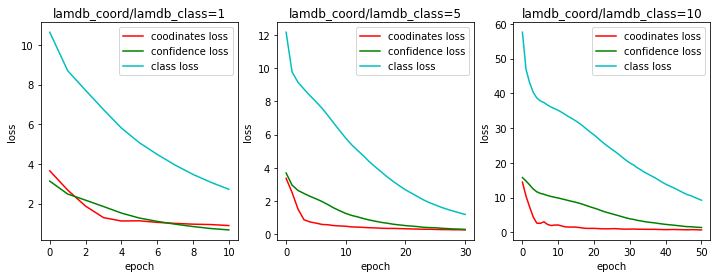

In [76]:
coordinates_loss = {}
confidence_loss = {}
class_loss = {}
index = {0: '1', 1: '5', 2: '10'}

# lambd_coord / lambd_class = 1
coordinates_loss[0] = 1 * np.array([3.65, 2.68, 1.87, 1.29, 1.12, 1.13, 1.05, 1.00, 0.96, 0.94, 0.89])
confidence_loss[0] = np.array([3.13, 2.48, 2.17, 1.85, 1.52, 1.27, 1.10, 0.96, 0.84, 0.74, 0.67])
class_loss[0] = np.array([10.64, 8.70, 7.71, 6.74, 5.81, 5.07, 4.48, 3.94, 3.47, 3.07, 2.72])

# lambd_coord / lambd_class = 5
coordinates_loss[1] = np.array([3.37, 2.52, 1.52, 0.88, 0.75, 0.68, 0.60, 0.58, 0.53, 0.51, 0.49, 0.45, 0.44, 0.42, 0.40, 0.39, 0.37,
                                0.36, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.31, 0.30, 0.29, 0.29, 0.28, 0.28, 0.27])
confidence_loss[1] = np.array([3.69, 2.96, 2.64, 2.46, 2.29, 2.14, 1.98, 1.79, 1.59, 1.42, 1.26, 1.14, 1.05, 0.95, 0.86, 0.79, 0.72, 
                               0.67, 0.61, 0.57, 0.53, 0.50, 0.47, 0.43, 0.41, 0.40, 0.37, 0.35, 0.33, 0.32, 0.30])
class_loss[1] = np.array([12.15, 9.76, 9.14, 8.73, 8.34, 7.98, 7.59, 7.15, 6.68, 6.23, 5.78, 5.38, 5.04, 4.71, 4.35, 4.04, 3.74, 3.44,
                          3.17, 2.92, 2.68, 2.48, 2.28, 2.08, 1.91, 1.77, 1.63, 1.51, 1.40, 1.30, 1.20])

# lambd_coord / lambd_class = 10
_, coordinates_loss[2], confidence_loss[2], class_loss[2] = Loss_summary_10
coordinates_loss[2] = np.array(coordinates_loss[2])


plt.figure(figsize = (12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(coordinates_loss[i], 'r-')
    plt.plot(confidence_loss[i], 'g-')
    plt.plot(class_loss[i], 'c-')
    plt.title('lamdb_coord/lamdb_class='+index[i])
    plt.legend(['coodinates loss', 'confidence loss', 'class loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')

<a id='test'></a>
# 6. Inference

- ${\frak{stage \; 1:}}$
$$
Raw \; image \quad
\frac{rescale}{} \quad
Standard \; input \quad
\frac{YOLO-VGG}{} \quad
\begin{cases}
\; t_o \\
\; t_x \\
\; t_y \\
\; t_w \\
\; t_h \\
\; c
\end{cases}
$$

In [3]:
## use yolo-vgg to inference one image
def yolo_vgg_inference(image_file):
    """
    Arguments:
    image_file -- path of test image file
    Returns:
    prediction -- numpy array of (1, 13, 13, 9x(5+21)), output of the model
    scale -- reshape ratio of image to 416x416
    """
    
    start_time = time.time()
    
    img = scipy.misc.imread(image_file)

    H, W, C = img.shape
    scale_W = W / CONFIG.W
    scale_H = H / CONFIG.H
    scale = [scale_W, scale_H]
    
    input_img = np.expand_dims(scipy.misc.imresize(img, (CONFIG.H, CONFIG.W)), axis=0) - CONFIG.MEANS
    y = np.zeros((1, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    # load model
    # load the meta graph and weights
    saver = tf.train.import_meta_graph(CONFIG.yolo_vgg_model)
    saver.restore(sess, tf.train.latest_checkpoint(CONFIG.weight_path))
    graph = tf.get_default_graph()

    pred = tf.get_collection("prediction")
    prediction = np.array(sess.run(pred, feed_dict = {"Placeholder:0": input_img}))[-1]
    
    end_time = time.time()
    time_consume = end_time - start_time
    print('Inference is completed and time consumed is %.2f s.'%time_consume)
    
    return prediction, scale

In [4]:
#tv
#image_file = '/home/nio/Documents/xgl/dataset/VOCdevkit/VOC2012/JPEGImages/2009_001779.jpg'
#image_file = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages/2009_001779.jpg'
#sheep
#image_file = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages/2007_000925.jpg'
#person
#image_file = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages/2007_004000.jpg'
#lots of persons
image_file = '/home/nio/Downloads/VOCdevkit/VOC2012/JPEGImages/2007_001526.jpg'
#image_file = '/home/nio/Downloads/1.jpg'
prediction, scale = yolo_vgg_inference(image_file)

INFO:tensorflow:Restoring parameters from /home/nio/Documents/xgl/code/model/model_yolo_vgg_new_nogd/yolo_vgg-100
Inference is completed and time consumed is 1.99 s.


<a id='postprocess'></a>
# 7. Postprocess

- ${\frak{stage \; 2}}$
$$\begin{cases}
\; t_o \\
\; t_x \\
\; t_y \\
\; t_w \\
\; t_h \\
\; c
\end{cases}
\Longrightarrow
\begin{cases}
Pr(object)*IOU(b, object) = \sigma(t_o) \\
b_x = c_x + \sigma(t_x) \\
b_y = c_y + \sigma(t_y) \\
b_w = p_w * \exp^{t_w}  \\
b_h = p_h * \exp^{t_h}  \\
Pr(Class|Object) = softmax(c)
\end{cases}
\Longrightarrow
\begin{cases}
Pr(Class) = Pr(Class|Object) \\
\qquad \qquad* Pr(object)*IOU(b, object) \\
xmin = b_x - \frac{b_w}{2} \\
ymin = b_y - \frac{b_h}{2} \\
xmax = b_x + \frac{b_w}{2} \\
ymax = b_y + \frac{b_h}{2} \\
\end{cases}
\quad \frac{rescale \; back}{} \quad
bbox
$$

- ${\frak{stage \; 3}}$
$$
bbox \quad
\frac{Filter \; with \; Pr}{} \quad
bbox \; with \; high \; score \quad
\frac{Non-max \; Suppression}{} \quad
final \; bbox
$$

## 7.1 Transform predicted label back to bounding box

In [62]:
def np_sigmoid(x):
    
    o = 1 / (1 + np.exp(-x))
    
    return o

def np_softmax(x):
    
    o = np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
    
    return o

# convert center index into center coordinate
def convert_index_to_coordinate(center_index):
    """
    Arguments:
    center_index -- center coordinate of bbox relative to image shape
    Returns:
    center_coordinate -- center
    """
    bx_index, by_index = center_index
    
    x_center = bx_index * CONFIG.ws
    y_center = by_index * CONFIG.hs
    
    center_coordinate = (x_center, y_center)
    
    return center_coordinate

## convert center coordinates + height and width to corner coordinates
def convert_center_to_corner(center_coordinate, bw, bh):
    
    x_center, y_center = center_coordinate
    xmin = x_center - bw // 2
    xmax = x_center + bw // 2
    ymin = y_center - bh // 2
    ymax = y_center + bh // 2
    
    corner_coordinates = (xmin, ymin, xmax, ymax)
    
    return corner_coordinates

## rescale predict box to true value
def rescale_predicted_bbox(coordinate, scale):
    
    xmin, ymin, xmax, ymax = coordinate
    scale_W, scale_H = scale
    
    rescaled_xmin = np.floor(xmin * scale_W)
    rescaled_ymin = np.floor(ymin * scale_H)
    rescaled_xmax = np.ceil(xmax * scale_W)
    rescaled_ymax = np.ceil(ymax * scale_H)
    
    rescaled_coordinate = (rescaled_xmin, rescaled_ymin, rescaled_xmax, rescaled_ymax)
    
    return rescaled_coordinate

## transform label back to coordinates for show
def transform_prediction_to_coord(prediction, scale):
    
    cell_class_summary = []
    bboxes = []
    
    y = np.reshape(prediction, (-1, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    pred = y[0]
    
    for c_x in range(CONFIG.S):
        for c_y in range(CONFIG.S):
            
            #store for cell drawing
            confidence_summary = np.max(np_sigmoid(pred[c_x, c_y, :, 0]))
            class_probability_summary = np_softmax(pred[c_x, c_y, :, 5:])
            if confidence_summary < CONFIG.confidence_threshold:
                cell_class_summary.append((CONFIG.num_classes, confidence_summary))
            else:
                summary = np.max(class_probability_summary, axis=0)
                cell_class_index = np.argmax(summary)
                cell_class_probabilty = np.max(summary)
                cell_class_summary.append((cell_class_index, cell_class_probabilty))
            
            for prior_ix in range(CONFIG.num_dimension_cluster):
                
                confidence = np_sigmoid(pred[c_x, c_y, prior_ix, 0])
                class_score = confidence * np.max(np_softmax(pred[c_x, c_y, prior_ix, 5:]))
                class_ix = np.argmax(pred[c_x, c_y, prior_ix, 5:])
                object_name = CONFIG.class_names[class_ix]
                
                #formula for YOLOv2, dropped here
                #b_x = c_x + np_sigmoid(pred[c_x, c_y, prior_ix, 1])
                #b_y = c_y + np_sigmoid(pred[c_x, c_y, prior_ix, 2])
                b_x = c_x + pred[c_x, c_y, prior_ix, 1]
                b_y = c_y + pred[c_x, c_y, prior_ix, 2]
                p_w, p_h = CONFIG.dimension_cluster[prior_ix]
                b_w = p_w * np.exp(pred[c_x, c_y, prior_ix, 3])
                b_h = p_h * np.exp(pred[c_x, c_y, prior_ix, 4])
                
                center_index = (b_x, b_y)
                center_coordinate = convert_index_to_coordinate(center_index)
                corner_coordinate = convert_center_to_corner(center_coordinate, b_w, b_h)

                rescaled_coordinate = rescale_predicted_bbox(corner_coordinate, scale)
                
                bboxes.append((confidence, class_score, object_name, rescaled_coordinate))
    
    return bboxes, cell_class_summary

## plot bboxes
def draw_predict_bboxes(file, bboxes, if_text=True):
    
    img = scipy.misc.imread(file)
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.axis('off')
    
    img_H = img.shape[0]
    img_W = img.shape[1]
    
    Fontsize = 10
    for bbox in bboxes:
        
        confidence, class_score, object_name, coordinate = bbox
        
        xmin, ymin, xmax, ymax = coordinate
        xmin = max(1, xmin)
        ymin = max(1, ymin)
        xmax = min(img_W - 1, xmax)
        ymax = min(img_H - 1, ymax)
        
        name_length = Fontsize * len(object_name)
        name_height = 1.5*Fontsize
        
        colorval = CONFIG.classes[object_name] / CONFIG.num_classes
        rect1 = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                              fill=False, 
                              edgecolor=[1-colorval, colorval, colorval])
        
        ax.add_patch(rect1)
        
        if if_text:
            
            rect2 = plt.Rectangle((xmin, ymin), 1.25*name_length, name_height, 
                                  facecolor=[1-colorval, colorval, colorval])
            ax.add_patch(rect2)
            ax.text(xmin, ymin+Fontsize, object_name + ' ' + '%.2f'%class_score, 
                    family = 'monospace', fontsize = Fontsize, color = 'black')

In [63]:
bboxes, cell_class_summary = transform_prediction_to_coord(prediction, scale)

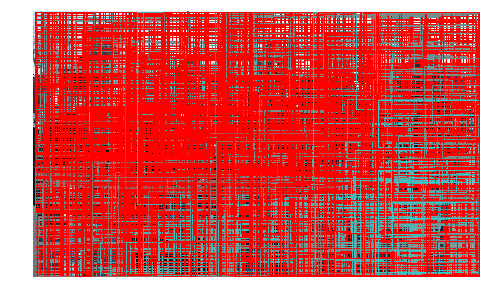

In [9]:
# draw all the anchor boxes
draw_predict_bboxes(image_file, bboxes, if_text=False)

In [86]:
# color each grid cell corresponding to its class and probability
def color_cell(file, cell_class_summary):
    
    img = scipy.misc.imread(file)
    scale_W = img.shape[1] / CONFIG.W
    scale_H = img.shape[0] / CONFIG.H
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.axis('off')
    
    y = np.reshape(prediction, (-1, CONFIG.S, CONFIG.S, CONFIG.num_dimension_cluster, 5+CONFIG.num_classes))
    
    for c_x in range(CONFIG.S):
        
        for c_y in range(CONFIG.S):
            
            cell_class_index, cell_class_probabilty = cell_class_summary[c_x*CONFIG.S + c_y]
            xmin = c_x * CONFIG.ws * scale_W
            ymin = c_y * CONFIG.hs * scale_H
            width = CONFIG.ws * scale_W
            height = CONFIG.hs * scale_H
            
            #color cell with respect to class index, smaller index tends to be red (say 'person')
            colorval = cell_class_index / (CONFIG.num_classes+1)
            rect = plt.Rectangle((xmin, ymin), width, height, 
                                 edgecolor='black', linewidth=2, 
                                 alpha=0.5, 
                                 facecolor=[1-colorval, colorval, colorval])
            ax.add_patch(rect)

    # add legend
    fig = plt.figure(figsize = (CONFIG.num_classes, 1))
    for i in range(CONFIG.num_classes+1):
        ax = fig.add_subplot(1, CONFIG.num_classes+1, i+1)
        colorval = i / (CONFIG.num_classes+1)
        rect = plt.Rectangle((0, 0), 1, 1, 
                             edgecolor='black', linewidth=1, 
                             facecolor=[1-colorval, colorval, colorval])
        ax.add_patch(rect)
        if i < CONFIG.num_classes:
            ax.title.set_text(CONFIG.class_names[i])
        else:
            ax.title.set_text('background')
        ax.axis('off')

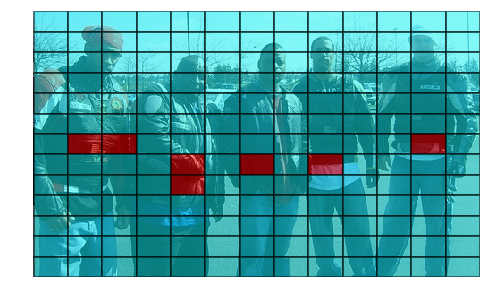

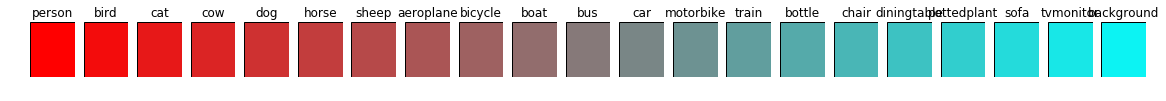

In [87]:
color_cell(image_file, cell_class_summary)

## 7.2 Filter predicted bounding boxes

### 7.2.1 Filter bbox by confidence threshold

In [11]:
## filter predict boxes by threshold and class (if it is predicted as background, just throw it away)
def filter_bbox_with_class_and_confidence(bboxes, threshold = CONFIG.confidence_threshold):
    
    new_bboxes = []
    
    for bbox in bboxes:
        
        confidence, class_score, object_name, coordinates = bbox
        
        if object_name != 'background':
        
            if confidence > threshold:
            
                new_bboxes.append(bbox)
            
    return new_bboxes

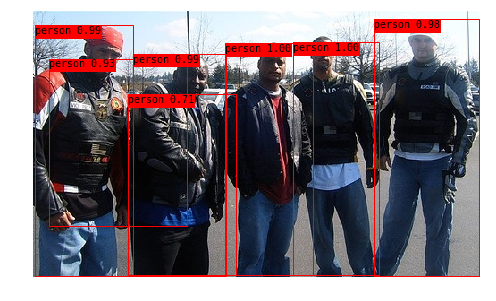

In [28]:
bboxes_after_threshold = filter_bbox_with_class_and_confidence(bboxes, threshold = 0.4)
draw_predict_bboxes(image_file, bboxes_after_threshold)

### 7.2.2 Filter bbox by Non-max Suppression

In [13]:
## Non-max Suppression
def obtain_object_names(bboxes):
    
    object_names = []
    
    for i, bbox in enumerate(bboxes):
        
        _, _, object_name, _ = bbox
        
        object_names.append(object_name)
    
    return set(object_names)
        
def cluster_bbox_by_object_name(bboxes, object_names):
    
    clustered_bboxes_summary = {}
    
    for j, bbox in enumerate(bboxes):
        
        _, _, object_name, _ = bbox
        
        if object_name in clustered_bboxes_summary.keys():
            
            clustered_bboxes_summary[object_name].append(bbox)

        else:

            clustered_bboxes_summary[object_name] = []
            clustered_bboxes_summary[object_name].append(bbox)
            
    return clustered_bboxes_summary
    
         
def NMS_per_class(clustered_bboxes, threshold):
    
    scores = []
    
    #get score of everay bbox and sort bbox by score
    for bbox in clustered_bboxes:
        
        confidence, class_score, _, _ = bbox
        scores.append(class_score)
    
    order = np.argsort(scores)
    
    nms_bboxes_per_class = []
    #filter bbox with nms in a reversed way
    while len(order) > 0:
        
        #if there is only one box left (with the highest score), just keep it
        if len(order) == 1:
            
            nms_bboxes_per_class.append(clustered_bboxes[order[0]])
            
        base_bbox = clustered_bboxes[order[0]]
        _, _, _, base_coordinates = base_bbox
        
        count = 0
        for i, sub_order in enumerate(order[1:]):
            
            _, _, _, coordinates = clustered_bboxes[sub_order]
            iou = calculate_IOU(base_coordinates, coordinates)
            
            if iou > threshold:
                break
            count += 1
        
        if count == len(order[1:]):
        
            nms_bboxes_per_class.append(base_bbox)
        
        order = order[1:]
        
    return nms_bboxes_per_class


def NMS(bboxes, threshold = CONFIG.nms_threshold):
    
    names = obtain_object_names(bboxes)
    
    clustered_bboxes_summary = cluster_bbox_by_object_name(bboxes, names)
    #print(clustered_bboxes_summary)
    nms_bboxes = []
    
    for object_name in clustered_bboxes_summary.keys():
        
        nms_bboxes_per_class = NMS_per_class(clustered_bboxes_summary[object_name], threshold)
        
        for bboxes in nms_bboxes_per_class:
            
            nms_bboxes.append(bboxes)
    
    return nms_bboxes

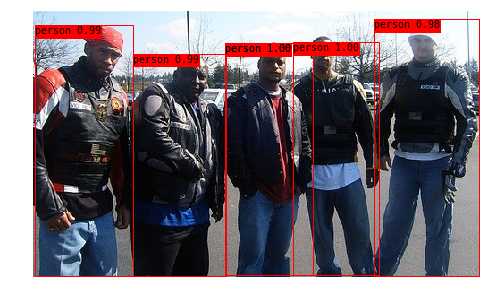

In [29]:
nms_bboxes = NMS(bboxes_after_threshold, threshold = 0.4)
draw_predict_bboxes(image_file, nms_bboxes)